In [2]:
!pip install --upgrade matplotlib

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro

#from matplotlib.widgets import Draggable
%matplotlib inline

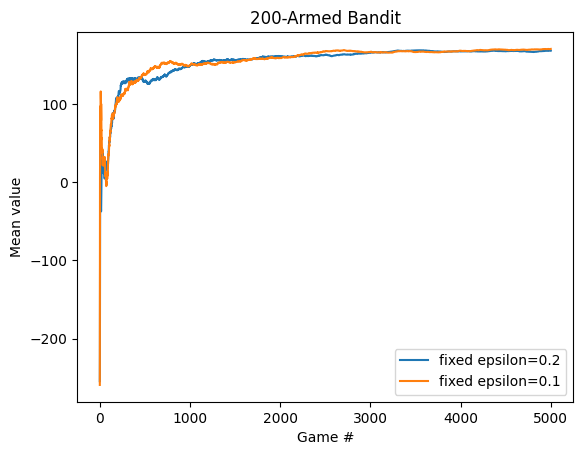

In [5]:
class OneArmBandit(object):
    """A single slot machine"""

    def __init__(self, mean, std):
        """
        Initialize the slot machine with a specific mean and standard deviation for its rewards.

        Args:
            mean: The average reward expected from the slot machine.
            std: The standard deviation of the rewards from the slot machine.
        """

        self.mean = mean
        self.std = std

    def draw(self):
        """
        Simulate drawing a reward from the slot machine.
        Returns:
            A  float representing the reward drawn from the slot machine using random method
        """

        return np.random.normal(self.mean, self.std)

        """
        Initialize the collection of slot machines.

        Args:
            N (int): The number of slot machines.
            means (list, optional): A list of custom means for each machine.
                If None, means will be assigned based on indices (0 to N-1).
            stds (list, optional): A list of custom standard deviations for each machine.
                If None, all machines will have a standard deviation of N.

        Raises:
            ValueError: If `N` is non-positive, or if `means` and `stds` do not match `N`.
        """
class NArmBandit(object):
    """A collection of N slot machines. Slot machine i has a mean of i and sigma of N"""
    def __init__(self,N):
      if N <= 0:
            raise ValueError("Number of slot machines must be positive.")

      self.N=N
      self.bandits=dict()  #  dictionary  maps each slot machine's index (from 0 to N-1) to its corresponding

      for i in range(N):
        self.bandits[i]=OneArmBandit(i,N)

    def draw_bandit(self,i):
        if i not in range(self.N):
            raise IndexError("Invalid slot machine index.")
        return self.bandits[i].draw()


class Player(object):
    """
    A player who plays on a collection of slot machines using an epsilon-greedy strategy.
    """
    def __init__(self,N,epsilon):
        self.game = NArmBandit(N)
        self.epsilon = epsilon      #  epsilon represents the exploration rate used in an epsilon-greedy strategy
        self.N = N
        self.Q = dict()             # Estimated values for each slot machine
        self.num_games=dict()       #  Number of times each slot machine has been played
        self.CumValue = 0           # Cumulative value obtained by the player

        for i in range(N):
            self.Q[i]=100 #optimistic init
            self.num_games[i]=0
        self.recorded_action=[]       # List of actions taken during play
        self.recorded_avg_value=[]    # List of average values after each game

    def play(self,games=1,epsilon_decay_factor=None,epsilon_decay_step=None):
        """The play method is the single API for the Player class.
        Arguments:
        games - number of games to play
        epsilon_decay_factor, epsilon_decay_step  -if these parameters are specified, epsilon will be multiplied by epsilon_decay_factor every epsilon_decay_step games. Therefore, epsilon_decay_factor better be <1.

        After the game, you can query the recorded_action for actions taken during the game and recorded_avg_value for mean utility/value.
        """
        for game in range(games):
            if (epsilon_decay_factor != None):
                if game % epsilon_decay_step == 0:
                    self.epsilon=  self.epsilon * epsilon_decay_factor

            exploit = np.random.random() >= self.epsilon
            bandit = None
            if exploit:
                #select which i to take
                bandit = max(self.Q, key=self.Q.get)
            else:
                #randomally select between all options
                bandit = np.random.randint(0,self.N)

            r = self.game.draw_bandit(bandit)
            #update Q value:
            self.Q[bandit] = self.Q[bandit] + (1.0 / (1.0 + self.num_games[bandit])) * (r - self.Q[bandit])

            self.num_games[bandit]=self.num_games[bandit]+1
            self.CumValue+=r
            self.recorded_avg_value.append(self.CumValue / float(game+1))
            self.recorded_action.append(bandit)

# Number of games
NUM_GAMES = 5000

# Number of Arms
N=200

player_02 = Player(N=N,epsilon=0.2)
player_02.play(NUM_GAMES)
player_01 = Player(N=N,epsilon=0.1)
player_01.play(NUM_GAMES)


plt.figure()
plt.plot(player_02.recorded_avg_value,label='fixed epsilon=0.2')
plt.plot(player_01.recorded_avg_value,label='fixed epsilon=0.1')

plt.title(str(N) + "-Armed Bandit")
plt.xlabel('Game #')
plt.ylabel('Mean value')
plt.legend()
plt.ion()
plt.show()